In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [27]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [28]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(
    train_dataset,[train_size,val_size]
)

batch_size=128

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [29]:
class DropoutCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,12,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(12,24,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(24,72,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(72*14*14,128)
        self.fc2 = nn.Linear(128,10)

        self.dropout = nn.Dropout(p=0.5)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x=self.dropout(x)
        x = F.relu(self.conv2(x))
        x=self.dropout(x)
        x = F.relu(self.conv3(x))
        x=self.dropout(x)
        x = self.pool(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x=self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = DropoutCNN().to(device)

print(cnn_model)

DropoutCNN(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14112, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [31]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=cnn_model.parameters(),
    lr=1e-3
)

In [32]:
def train_one_epoch(model,device,loader,optimizer,criterion):
    model.train()
    running_loss=0.0
    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()*images.size(0)
    epoch_loss = running_loss/len(loader.dataset)
    return epoch_loss



In [33]:
def evaluate(model,loader,criterion,device):
    model.eval()
    running_loss=0.0
    correct=0
    with torch.no_grad():
        for images,labels in loader:
            images=images.to(device)
            labels=labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss+=loss.item()*images.size(0)

            preds=outputs.argmax(dim=1)
            correct+=(preds==labels).sum().item()
    val_loss = running_loss/len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return val_loss,accuracy


In [34]:
train_losses_cnn = []
val_losses_cnn=[]
val_acc_cnn = []

num_epochs=10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=cnn_model,device=device,
        loader=train_loader,optimizer=optimizer,
        criterion=criterion
    )
    val_loss,val_acc = evaluate(
        cnn_model,val_loader,criterion,device
    )

    train_losses_cnn.append(train_loss)
    val_losses_cnn.append(val_loss)
    val_acc_cnn.append(val_acc)

    print(
        f"Epoch {epoch+1} |"
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 1 |Train Loss: 0.4879 | Val Loss: 0.1295 | Val Acc: 0.9688
Epoch 2 |Train Loss: 0.1722 | Val Loss: 0.0833 | Val Acc: 0.9793
Epoch 3 |Train Loss: 0.1312 | Val Loss: 0.0772 | Val Acc: 0.9810
Epoch 4 |Train Loss: 0.1115 | Val Loss: 0.0582 | Val Acc: 0.9828
Epoch 5 |Train Loss: 0.0956 | Val Loss: 0.0499 | Val Acc: 0.9868
Epoch 6 |Train Loss: 0.0860 | Val Loss: 0.0496 | Val Acc: 0.9863
Epoch 7 |Train Loss: 0.0842 | Val Loss: 0.0462 | Val Acc: 0.9865
Epoch 8 |Train Loss: 0.0782 | Val Loss: 0.0473 | Val Acc: 0.9877
Epoch 9 |Train Loss: 0.0701 | Val Loss: 0.0420 | Val Acc: 0.9883
Epoch 10 |Train Loss: 0.0682 | Val Loss: 0.0409 | Val Acc: 0.9875


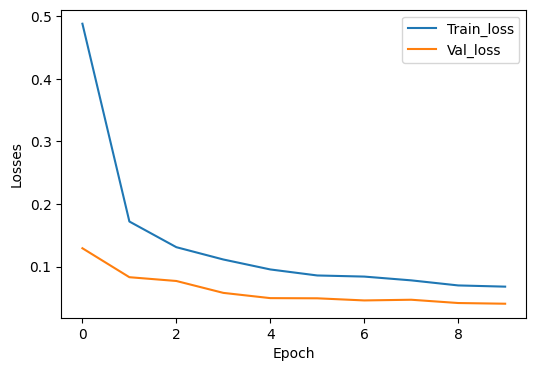

In [35]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_cnn,label="Train_loss")
plt.plot(val_losses_cnn,label="Val_loss")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend()
plt.show()


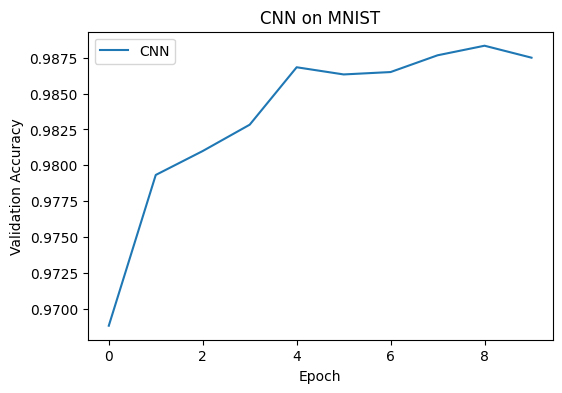

In [36]:
plt.figure(figsize=(6,4))
plt.plot(val_acc_cnn, label="CNN")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("CNN on MNIST")
plt.show()


In [37]:
import math
def visualize_conv1_filters(model):
  weights = model.conv1.weight.data.cpu()

  num_filters = weights.shape[0]
  cols = 7
  rows = math.ceil(num_filters / cols)

  plt.figure(figsize=(cols, rows))
  for i in range(num_filters):
    plt.subplot(rows, cols, i+1)
    plt.imshow(weights[i,0], cmap="gray")
    plt.axis("off")

  plt.suptitle("CNN Conv1 Learned Filters")
  plt.show()

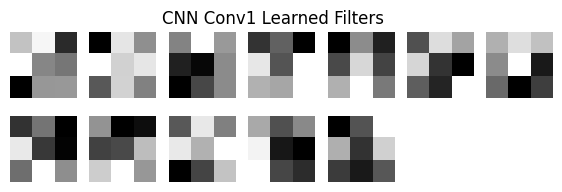

In [38]:
visualize_conv1_filters(cnn_model)

In [39]:
class CNNWithActivations(DropoutCNN):
    def forward(self, x):
        activations = {}
        x = F.relu(self.conv1(x))
        activations["conv1"] = x

        x = F.relu(self.conv2(x))
        activations["conv2"] = x

        x = F.relu(self.conv3(x))
        activations["conv3"] = x

        x = self.pool(x)
        activations["pool"] = x

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        return x, activations

In [40]:
def visualize_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)

    _, activations = model(image)

    for name, act in activations.items():
        act = act.cpu().detach()
        num_maps = min(16, act.shape[1])
        plt.figure(figsize=(12,1))
        for i in range(num_maps):
            plt.subplot(1, num_maps, i + 1)
            plt.imshow(act[0, i], cmap="gray")
            plt.axis("off")
            plt.suptitle(name)
    plt.show()


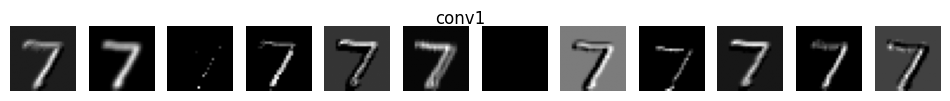

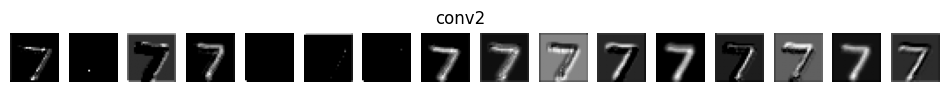

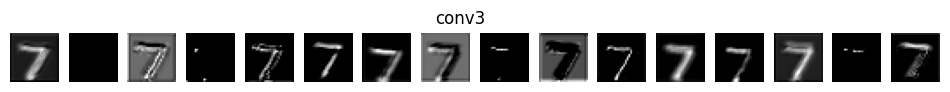

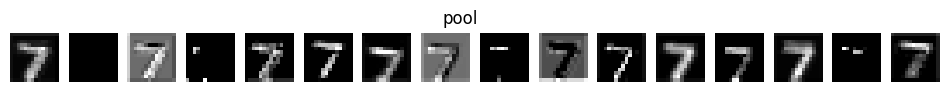

In [41]:
cnn_with_activations = CNNWithActivations().to(device)

sample_img, label = test_dataset[0]
visualize_feature_maps(cnn_with_activations, sample_img)

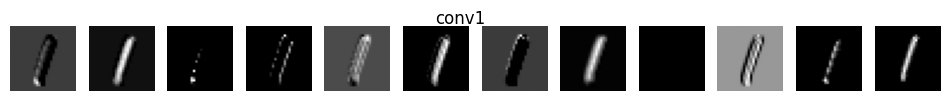

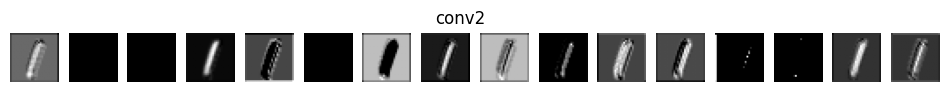

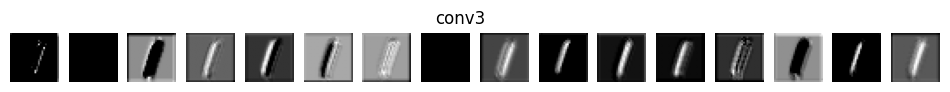

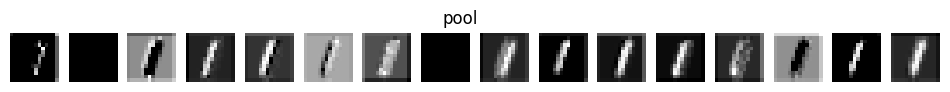

In [42]:
cnn_with_activations = CNNWithActivations().to(device)

sample_img, label = test_dataset[5]
visualize_feature_maps(cnn_with_activations, sample_img)